In [6]:
import os
import sys
import matplotlib.pyplot as plt
from itertools import combinations
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth



In [7]:
def generate_combinations(old_combinations):
    items_types_in_previous_step = np.unique(old_combinations.flatten())
    for old_combination in old_combinations:
        max_combination = old_combination[-1]
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]
        old_tuple = tuple(old_combination)
        for item in valid_items:
            yield from old_tuple
            yield item

def apriori(
    df, min_support=0.5, use_colnames=False, max_len=None, ):
    def _support(_x, _n_rows):
        out = np.sum(_x, axis=0) / _n_rows
        return np.array(out).reshape(-1)
    X = df.values
    support = _support(X, X.shape[0])
    ary_col_idx = np.arange(X.shape[1])
    support_dict = {1: support[support >= min_support]}
    itemset_dict = {1: ary_col_idx[support >= min_support].reshape(-1, 1)}
    max_itemset = 1
    rows_count = float(X.shape[0])

    while max_itemset and max_itemset < (max_len or float("inf")):
        next_max_itemset = max_itemset + 1
        combin = generate_combinations(itemset_dict[max_itemset])
        combin = np.fromiter(combin, dtype=int)
        combin = combin.reshape(-1, next_max_itemset)

        if combin.size == 0:
            break
        _bools = np.all(X[:, combin], axis=2)

        support = _support(np.array(_bools), rows_count)
        _mask = (support >= min_support).reshape(-1)
        if any(_mask):
            itemset_dict[next_max_itemset] = np.array(combin[_mask])
            support_dict[next_max_itemset] = np.array(support[_mask])
            max_itemset = next_max_itemset
        else:
            break

    all_res = []
    for k in sorted(itemset_dict):
        support = pd.Series(support_dict[k])
        itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]], dtype="object")

        res = pd.concat((support, itemsets), axis=1)
        all_res.append(res)

    res_df = pd.concat(all_res)
    res_df.columns = ["support", "itemsets"]
    if use_colnames:
        mapping = {idx: item for idx, item in enumerate(df.columns)}
        res_df["itemsets"] = res_df["itemsets"].apply(
            lambda x: frozenset([mapping[i] for i in x])
        )
    res_df = res_df.reset_index(drop=True)

    return res_df

def association_rules(df, metric="confidence", min_threshold=0.8):
    def conviction_helper(sAC, sA, sC):
        confidence = sAC / sA
        conviction = np.empty(confidence.shape, dtype=float)
        if not len(conviction.shape):
            conviction = conviction[np.newaxis]
            confidence = confidence[np.newaxis]
            sAC = sAC[np.newaxis]
            sA = sA[np.newaxis]
            sC = sC[np.newaxis]
        conviction[:] = np.inf
        conviction[confidence < 1.0] = (1.0 - sC[confidence < 1.0]) / (
            1.0 - confidence[confidence < 1.0]
        )
        return conviction

    def zhangs_metric_helper(sAC, sA, sC):
        denominator = np.maximum(sAC * (1 - sA), sA * (sC - sAC))
        numerator = metric_dict["leverage"](sAC, sA, sC)
        with np.errstate(divide="ignore", invalid="ignore"):
            zhangs_metric = np.where(denominator == 0, 0, numerator / denominator)
        return zhangs_metric
    metric_dict = {
        "antecedent support": lambda _, sA, __: sA,
        "consequent support": lambda _, __, sC: sC,
        "support": lambda sAC, _, __: sAC,
        "confidence": lambda sAC, sA, _: sAC / sA,
        "lift": lambda sAC, sA, sC: metric_dict["confidence"](sAC, sA, sC) / sC,
        "leverage": lambda sAC, sA, sC: metric_dict["support"](sAC, sA, sC) - sA * sC,
        "conviction": lambda sAC, sA, sC: conviction_helper(sAC, sA, sC),
        "zhangs_metric": lambda sAC, sA, sC: zhangs_metric_helper(sAC, sA, sC),
    }
    columns_ordered = [
        "antecedent support",
        "consequent support",
        "support",
        "confidence",
        "lift",
        "leverage",
        "conviction",
        "zhangs_metric",
    ]
    keys = df["itemsets"].values
    values = df["support"].values
    frozenset_vect = np.vectorize(lambda x: frozenset(x))
    frequent_items_dict = dict(zip(frozenset_vect(keys), values))
    rule_antecedents = []
    rule_consequents = []
    rule_supports = []

    for k in frequent_items_dict.keys():
        sAC = frequent_items_dict[k]
        for idx in range(len(k) - 1, 0, -1):
            for c in combinations(k, r=idx):
                antecedent = frozenset(c)
                consequent = k.difference(antecedent)

                sA = frequent_items_dict[antecedent]
                sC = frequent_items_dict[consequent]
                score = metric_dict[metric](sAC, sA, sC)
                if score >= min_threshold:
                    rule_antecedents.append(antecedent)
                    rule_consequents.append(consequent)
                    rule_supports.append([sAC, sA, sC])

    if not rule_supports:
        return pd.DataFrame(columns=["antecedents", "consequents"] + columns_ordered)

    else:
        rule_supports = np.array(rule_supports).T.astype(float)
        df_res = pd.DataFrame(
            data=list(zip(rule_antecedents, rule_consequents)),
            columns=["antecedents", "consequents"],
        )


        sAC = rule_supports[0]
        sA = rule_supports[1]
        sC = rule_supports[2]
        for m in columns_ordered:
            df_res[m] = metric_dict[m](sAC, sA, sC)

        return df_res
    
def read_data(fp):
    with open(fp, mode="r", encoding="utf-8") as f:
        all_lines=[line.strip() for line in list(f.readlines())]
    sites=[]
    Cs=[]
    Vs=[]
    for line in all_lines:
        line=line.split(",")
        if line[0] == "A":
            # A,1287,1,"International AutoRoute","/autoroute"
            item={
                "site_id": int(line[1]),
                "title": str(line[-2]),
                "url": str(line[-1]),
            }  
            sites.append(item)
            # C,"26118",26118
            # V,1008,1
        elif line[0]=="C":
            Cs.append({
                "C_id": int(line[2]),
                "sites": []
            })
        elif line[0]=="V":
            Cs[-1]["sites"].append(int(line[1]))
    # 清洗数据，处理缺失值
    sites=[x for x in sites if all([k in x.keys() for k in ["site_id", "title", "url"]])]
    Cs=[x for x in Cs if len(x["sites"])>0]
    # 提取用户浏览记录
    Vs=[x["sites"] for x in Cs]
    return sites, Cs, Vs


In [8]:
def analysis(sites, Cs, Vs):
    # 分析最常被访问的页面、页面访问量分布等。
    # 页面
    unique_sites=list(set([x["site_id"] for x in sites]))
    all_Vs=[x for y in Vs for x in y]
    # 每个页面的访问量
    visited_count=[all_Vs.count(x) for x in unique_sites]
    # 访问量最多的前五个页面
    site_visit_counts = dict(zip(unique_sites, visited_count))
    top_5_sites = sorted(site_visit_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    # 打印访问量最多的前五个页面
    print("Top 5 most visited pages:")
    for site, count in top_5_sites:
        print(f"Site ID: {site}, Visit Count: {count}")
    # 画访问量分布图
    plt.bar(unique_sites, visited_count)
    plt.xlabel('Site ID')
    plt.ylabel('Visit Count')
    plt.title('Page Visit Distribution')
    plt.show()

    # 使用TransactionEncoder处理数据
    te = TransactionEncoder()
    te_data = te.fit(Vs).transform(Vs)
    df = pd.DataFrame(te_data, columns=te.columns_)

    min_support=0.1
    # 使用Apriori算法找到频繁项集
    apriori_frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    print("Apriori Frequent Itemsets:")
    print(apriori_frequent_itemsets)

    # 使用FP-growth算法找到频繁项集
    fp_growth_frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    print("FP-growth Frequent Itemsets:")
    print(fp_growth_frequent_itemsets)

    # 计算关联规则
    rules = association_rules(apriori_frequent_itemsets, metric="confidence", min_threshold=0)
    print("Association Rules:")
    print(rules)
    # 筛选强关联规则
    strong_rules = rules[(rules['confidence'] >= 0.5) & (rules['lift'] >= 1.5)]
    print("Strong Association Rules:")
    print(strong_rules)

In [9]:
sites, Cs, Vs=read_data(fp="../data/anonymous-msweb.data")
print(f"len of sites: {len(sites)}")
print(f"len of Cs: {len(Cs)}")
print(f"len of Vs: {len(Vs)}")

len of sites: 294
len of Cs: 32711
len of Vs: 32711


Top 5 most visited pages:
Site ID: 1008, Visit Count: 10836
Site ID: 1034, Visit Count: 9383
Site ID: 1004, Visit Count: 8463
Site ID: 1018, Visit Count: 5330
Site ID: 1017, Visit Count: 5108


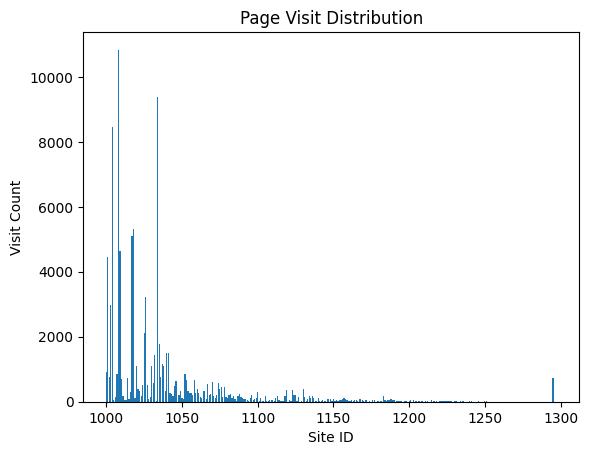

Apriori Frequent Itemsets:
    support      itemsets
0  0.136070        (1001)
1  0.258720        (1004)
2  0.331265        (1008)
3  0.141481        (1009)
4  0.156155        (1017)
5  0.162942        (1018)
6  0.286845        (1034)
7  0.160802  (1008, 1034)
FP-growth Frequent Itemsets:
    support      itemsets
0  0.136070        (1001)
1  0.258720        (1004)
2  0.331265        (1008)
3  0.141481        (1009)
4  0.162942        (1018)
5  0.156155        (1017)
6  0.286845        (1034)
7  0.160802  (1008, 1034)
Association Rules:
  antecedents consequents  antecedent support  consequent support   support  \
0      (1008)      (1034)            0.331265            0.286845  0.160802   
1      (1034)      (1008)            0.286845            0.331265  0.160802   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.485419  1.692267   0.06578    1.385894       0.611717  
1    0.560588  1.692267   0.06578    1.521888       0.573616  
Strong Association Rules:
  an

In [10]:
analysis(sites, Cs, Vs)

# 分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。

根据以上得到的关联规则，我们推荐网站对细分网址纪念性结构化重组，以方便用户进行感兴趣的网页之间的跳转。
例如我们得到的Strong Association Rules: 1034->1008